In [1]:
import torch
import torch.nn as nn
import torch.autograd
from torch.autograd import Variable
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.utils.data as data

In [37]:
#### cvt2tensor = transforms.ToTensor()
cvt2pil = transforms.ToPILImage()

class Spacenet_Dataset(data.Dataset):
    def __init__(self, annotationsFile,train = True, transform=None, target_transform = None):
        files = open(annotationsFile,'r')
        self.transform=transform
        self.target_transform=target_transform
        items=[]
        #print(lines[0].split('\n'))
        for line in files:
            #print(line)
            imp,_ = line.split('\n')
            ip,out = imp.split(' ')
            out = out[:-4]+'segobj.png'
            item = [ip,out]
            items.append(item)
        self.data = items
        self.inp_img_paths=[]
        self.out_img_paths=[]
        for dat in self.data:
            self.inp_img_paths.append(dat[0])
            self.out_img_paths.append(dat[1])
        #print(len(inp_img_paths))
              
    def getImage(self,path):
        pil_image = Image.open(path)
        pil_image = pil_image.convert('RGB')
        return pil_image

    def __getitem__(self, index):
        cur_in_path = self.inp_img_paths[index]
        cur_out_path = self.out_img_paths[index]
        in_image = self.getImage(cur_in_path)
        out_image = self.getImage(cur_out_path)
        
        if self.transform is not None:
            in_image = self.transform(in_image)
            out_image = self.transform(out_image)
        return in_image, out_image
    
    def __len__(self):
        return len(self.inp_img_paths)

imgTransform = transforms.Compose([transforms.Scale((400, 400)),
                                   transforms.ToTensor()])

trainData = Spacenet_Dataset("/home/dipshil/Spacenet_things/annotations/trainval.txt",transform=imgTransform)
valData = Spacenet_Dataset("/home/dipshil/Spacenet_things/annotations/test.txt",transform=imgTransform)
inp,out = trainData[0]

In [38]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        # Convolutional layers.
        self.conv1 = nn.Conv2d(3, 64, 8, stride = 2)
        self.conv2 = nn.Conv2d(64, 128, 6, stride = 2)
        self.conv3 = nn.Conv2d(128, 256, 7,stride = 3)
        self.conv4 = nn.Conv2d(256, 512, 3,stride = 2, padding =2)
        
        self.deconv1 = nn.ConvTranspose2d(512,256,3,stride=2,padding=1)
        self.deconv2 = nn.ConvTranspose2d(256,128,7,stride=3)
        self.deconv3 = nn.ConvTranspose2d(128,64,6,stride=2)
        self.deconv4 = nn.ConvTranspose2d(64,3,8,stride=2,padding=1)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        out = F.relu(self.deconv3(out))
        out = F.relu(self.deconv4(out))
        
        return out

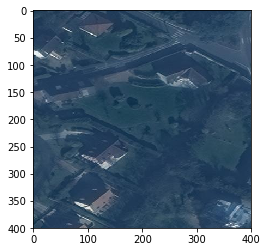

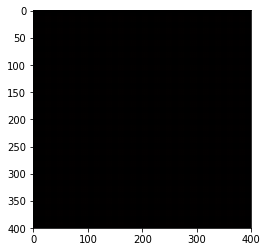

In [39]:
import random

inp,out = trainData[random.randint(0,3673)] # change it to Valdata if necessary, dont forget to change value inside rand()
inp = inp.view(-1,3,400,400)
model = MyNet()
sample_ip = torch.autograd.Variable(inp)
sample_out = model(sample_ip)
sample_out = sample_out.view(-1,400,400)
sample_out = cvt2pil(sample_out.data.cpu())
sample_inp = cvt2pil(inp.view(-1,400,400)) 
plt.imshow(sample_inp)
plt.show()
plt.imshow(sample_out)
plt.show()

In [40]:
imgTransform = transforms.Compose([transforms.Scale((400, 400)),
                                   transforms.ToTensor()])

trainData = Spacenet_Dataset("/home/dipshil/Spacenet_things/annotations/trainval.txt",transform=imgTransform)
valData = Spacenet_Dataset("/home/dipshil/Spacenet_things/annotations/test.txt",transform=imgTransform)

trainLoader = torch.utils.data.DataLoader(trainData, batch_size = 1, 
                                          shuffle = True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(valData, batch_size = 1, 
                                        shuffle = False, num_workers = 0)

In [41]:
from tqdm import tqdm as tqdm

train_loss=[]
test_loss=[]

def train_rnn_model(model, criterion, optimizer, trainData, valData, n_epochs = 10, use_gpu = False):      
    
    if use_gpu:
        print('using GPU!')
        model = model.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        cum_loss = 0.0
        accuracy = 0
        
        # Make a pass over the training data.
        t = tqdm(trainData, desc = 'Training epoch %d' % epoch)
        model.train()  # This is important to call before training!
        for (i,(ip_image, out_image)) in enumerate(t): 
            #print(ip_image.size())
            #print(out_image.size())
            input_image = torch.autograd.Variable(ip_image)
            target = torch.autograd.Variable(out_image)

            if use_gpu:
                input_image = input_image.cuda()
                target = target.cuda()
                
            y_ = model(input_image)

            loss = criterion(y_, target)
            cum_loss += loss.data[0]

            optimizer.zero_grad()

            loss.backward()
                    # Weight and bias updates.
            optimizer.step()                

            # logging information.
            t.set_postfix(loss = cum_loss / (1 + i)) 

        train_loss.append(cum_loss/(i+1))


        # Make a pass over the validation data.
        cum_loss = 0.0
        accuracy = 0
        
        t = tqdm(valData, desc = 'Validation epoch %d' % epoch)
        model.eval()  # This is important to call before evaluating!
        for (i,(ip_image,out_image)) in enumerate(t): 
        
            input_image = torch.autograd.Variable(ip_image)
            target = torch.autograd.Variable(out_image)

            if use_gpu:
                input_image = input_image.cuda()
                target = target.cuda()
                
            y_ = model(input_image)

            loss = criterion(y_, target)
            cum_loss += loss.data[0]
            
        test_loss.append(cum_loss/(i+1))
    return model

model = MyNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)


# Train the previously defined model.
trained_model = train_rnn_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = False)

Training epoch 0:   1%|          | 39/3674 [00:31<48:35,  1.25it/s, loss=0.0365]   

KeyboardInterrupt: 